In [14]:

import re
from html import unescape
import os
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import nltk
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import email
import joblib
import tarfile
import urlextract
import urllib.request
import email.policy
import numpy as np
from collections import Counter
from scipy.sparse import csr_matrix


In [15]:
# Descargar el conjunto de datos
RAIZ_DESCARGA = "http://spamassassin.apache.org/old/publiccorpus/"
URL_HAM = RAIZ_DESCARGA + "20030228_easy_ham.tar.bz2"
URL_SPAM = RAIZ_DESCARGA + "20030228_spam.tar.bz2"
RUTA_SPAM = os.path.join("datasets", "spam")


In [16]:
def obtener_datos_spam(url_ham=URL_HAM, url_spam=URL_SPAM, ruta_spam=RUTA_SPAM):
    if not os.path.isdir(ruta_spam):
        os.makedirs(ruta_spam)
    for nombre_archivo, url in (("ham.tar.bz2", url_ham), ("spam.tar.bz2", url_spam)):
        ruta = os.path.join(ruta_spam, nombre_archivo)
        if not os.path.isfile(ruta):
            urllib.request.urlretrieve(url, ruta)
        archivo_tar_bz2 = tarfile.open(ruta)
        archivo_tar_bz2.extractall(path=ruta_spam)
        archivo_tar_bz2.close()


obtener_datos_spam()

In [17]:
# Cargar todos los correos electrónicos
DIR_HAM = os.path.join(RUTA_SPAM, "easy_ham")
DIR_SPAM = os.path.join(RUTA_SPAM, "spam")
nombres_ham = [nombre for nombre in sorted(os.listdir(DIR_HAM)) if len(nombre) > 5]
nombres_spam = [nombre for nombre in sorted(os.listdir(DIR_SPAM)) if len(nombre) > 5]


def cargar_email(es_spam, nombre_archivo, ruta_spam=RUTA_SPAM):
    directorio = "spam" if es_spam else "easy_ham"
    with open(os.path.join(ruta_spam, directorio, nombre_archivo), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)


correos_ham = [cargar_email(es_spam=False, nombre_archivo=nombre) for nombre in nombres_ham]
correos_spam = [cargar_email(es_spam=True, nombre_archivo=nombre) for nombre in nombres_spam]


In [18]:
# Crear algunas funciones básicas
def obtener_estructura_email(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(
            ", ".join([obtener_estructura_email(sub_email) for sub_email in payload])
        )
    else:
        return email.get_content_type()


def contador_estructuras(correos):
    estructuras = Counter()
    for email in correos:
        estructura = obtener_estructura_email(email)
        estructuras[estructura] += 1
    return estructuras



In [19]:
def html_a_texto_plano(html):
    
    patrones = [
        (r"<head.*?>.*?</head>", ""),       # Eliminar contenido dentro de <head>
        (r"<a\s.*?>", " HIPERVINCULO "),    # Reemplazar enlaces por "HIPERVINCULO"
        (r"<.*?>", ""),                     # Eliminar cualquier etiqueta HTML restante
        (r"(\s*\n)+", "\n"),                # Colapsar saltos de línea múltiples
    ]
    # Aplicar todas las transformaciones en una única iteración
    regex = re.compile("|".join(f"({patron})" for patron, _ in patrones), flags=re.M | re.S | re.I)
    reemplazos = [replacement for _, replacement in patrones]
    def reemplazar(m):
        for i, replacement in enumerate(reemplazos):
            if m.group(i + 1):  # Match encontrado para este subpatrón
                return replacement
        return m.group(0)  # Caso por defecto (aunque no debería ocurrir)
    
    texto = regex.sub(reemplazar, html)
    return unescape(texto)



def email_a_texto(email):
    html = None
    for parte in email.walk():
        ctype = parte.get_content_type()
        if ctype not in ("text/plain", "text/html"):
            continue
        try:
            # Obtener contenido con decodificación explícita
            contenido = parte.get_payload(decode=True)
            contenido = contenido.decode(parte.get_content_charset() or "utf-8", errors="replace")
        except Exception:  # Captura cualquier error inesperado
            contenido = parte.get_payload()
        if ctype == "text/plain":
            return contenido.strip()
        else:
            html = contenido
    if html:
        return html_a_texto_plano(html)


In [20]:
# Dividir en conjunto de entrenamiento y prueba
X = np.array(correos_ham + correos_spam, dtype=object)
y = np.array([0] * len(correos_ham) + [1] * len(correos_spam))

X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [21]:
# Crear algunos transformadores y transformar el conjunto de datos
import re
import numpy as np
from collections import Counter
from scipy.sparse import csr_matrix
from nltk.stem import PorterStemmer
from urlextract import URLExtract
from sklearn.base import BaseEstimator, TransformerMixin

# Inicializar recursos globales
stemmer = PorterStemmer()
extractor_urls = URLExtract()

In [22]:
class TransformadorEmailACounterDePalabras(BaseEstimator, TransformerMixin):
    """
    Convierte una lista de correos electrónicos en representaciones de conteo de palabras.
    Opciones para manipulación de texto: minúsculas, eliminación de puntuación, stemming, etc.
    """
    def __init__(
        self,
        quitar_encabezados=True,
        convertir_minusculas=True,
        eliminar_puntuacion=True,
        reemplazar_urls=True,
        reemplazar_numeros=True,
        stemming=True,
    ):
        self.quitar_encabezados = quitar_encabezados
        self.convertir_minusculas = convertir_minusculas
        self.eliminar_puntuacion = eliminar_puntuacion
        self.reemplazar_urls = reemplazar_urls
        self.reemplazar_numeros = reemplazar_numeros
        self.stemming = stemming

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        def procesar_email(email):
            texto = email_a_texto(email) or ""
            if self.convertir_minusculas:
                texto = texto.lower()
            if self.reemplazar_urls:
                texto = self._reemplazar_urls(texto)
            if self.reemplazar_numeros:
                texto = re.sub(r"\d+(?:\.\d*)?(?:[eE][+-]?\d+)?", "NUMERO", texto)
            if self.eliminar_puntuacion:
                texto = re.sub(r"\W+", " ", texto, flags=re.M)
            return self._contar_palabras(texto)

        return np.array([procesar_email(email) for email in X])

    def _reemplazar_urls(self, texto):
        urls = extractor_urls.find_urls(texto)
        urls = sorted(set(urls), key=len, reverse=True)
        for url in urls:
            texto = texto.replace(url, " URL ")
        return texto

    def _contar_palabras(self, texto):
        palabras = texto.split()
        conteos = Counter(palabras)
        if self.stemming:
            conteos_stemmed = Counter()
            for palabra, conteo in conteos.items():
                palabra_stemmed = stemmer.stem(palabra)
                conteos_stemmed[palabra_stemmed] += conteo
            return conteos_stemmed
        return conteos


class TransformadorCounterDePalabrasAVector(BaseEstimator, TransformerMixin):
    """
    Convierte una lista de conteos de palabras (Counter) en una matriz dispersa (CSR) basada en un vocabulario limitado.
    """
    def __init__(self, tamanio_vocabulario=1000):
        self.tamanio_vocabulario = tamanio_vocabulario

    def fit(self, X, y=None):
        conteo_total = Counter()
        for conteo_palabras in X:
            for palabra, conteo in conteo_palabras.items():
                conteo_total[palabra] += min(conteo, 10)
        mas_comunes = conteo_total.most_common(self.tamanio_vocabulario)
        self.vocabulario_ = {palabra: indice + 1 for indice, (palabra, _) in enumerate(mas_comunes)}
        return self

    def transform(self, X, y=None):
        filas, columnas, datos = [], [], []

        for fila, conteo_palabras in enumerate(X):
            for palabra, conteo in conteo_palabras.items():
                indice_columna = self.vocabulario_.get(palabra, 0)
                filas.append(fila)
                columnas.append(indice_columna)
                datos.append(conteo)

        return csr_matrix(
            (datos, (filas, columnas)),
            shape=(len(X), self.tamanio_vocabulario + 1),
        )



In [23]:
# Crear un Pipeline y transformar el conjunto de datos
pipeline_preprocesamiento = Pipeline(
    [
        ("email_a_counter_de_palabras", TransformadorEmailACounterDePalabras()),
        ("counter_de_palabras_a_vector", TransformadorCounterDePalabrasAVector()),
    ]
)

In [24]:
# Preprocesar datos
X_entrenamiento_transformado = pipeline_preprocesamiento.fit_transform(X_entrenamiento)
X_prueba_transformado = pipeline_preprocesamiento.transform(X_prueba)

# Entrenar y evaluar el modelo de regresión logística
modelo_log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42, n_jobs=-1)

# Validación cruzada
score = cross_val_score(modelo_log_clf, X_entrenamiento_transformado, y_entrenamiento, cv=3, verbose=3, n_jobs=-1)

# Entrenar modelo en todo el conjunto de entrenamiento
modelo_log_clf.fit(X_entrenamiento_transformado, y_entrenamiento)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished


LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)

In [25]:
# Realizar predicciones
y_pred = modelo_log_clf.predict(X_prueba_transformado)
# Imprimir las métricas
print(f"Precisión de validación cruzada = {score.mean():.3f}")
print(f"Precisión = {precision_score(y_prueba, y_pred):.3f}")
print(f"Recall = {recall_score(y_prueba, y_pred):.3f}")
print(f"F1 = {f1_score(y_prueba, y_pred):.3f}")
print(f"AUC = {roc_auc_score(y_prueba, y_pred):.3f}")


Precisión de validación cruzada = 0.985
Precisión = 0.959
Recall = 0.979
F1 = 0.969
AUC = 0.986


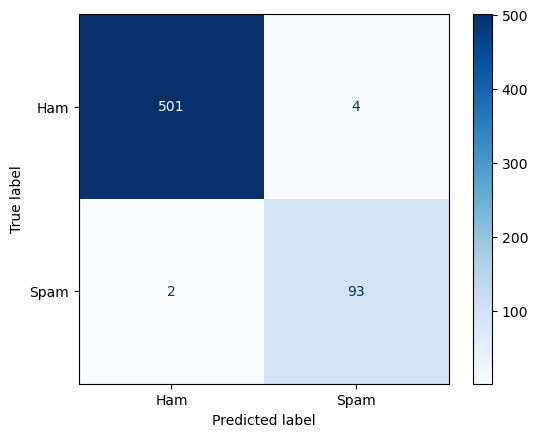

In [26]:
# Generar la matriz de confusión
cm = confusion_matrix(y_prueba, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham", "Spam"])
cm_display.plot(cmap="Blues")

# Mostrar el gráfico de la matriz de confusión
plt.show()

# Guardar nuestro modelo con joblib
joblib.dump(modelo_log_clf, "Clasificador_Spam.pkl")
joblib.dump(pipeline_preprocesamiento, "pipeline_preprocesamiento.pkl")

# Cargar los modelos
Modelo_Clasificador_Spam_Cargado = joblib.load("Clasificador_Spam.pkl")
Pipeline_Preprocesamiento_Cargado = joblib.load("pipeline_preprocesamiento.pkl")
